<a href="https://colab.research.google.com/github/cristianobattistini/oxe-bt-pipeline/blob/refactor-vlm-modular/nb/push_to_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation: BLEU and ROUGE


## Import and download libraries

In [ ]:
%%capture
import re, torch

# Rileva versione di torch per scegliere xformers compatibile (come nel tuo codice unsloth)
v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
if v == "2.9":
    xformers = "xformers==0.0.33.post1"
elif v == "2.8":
    xformers = "xformers==0.0.32.post2"
else:
    xformers = "xformers==0.0.29.post3"

# --------------------------------------------------------------------
# Stack base per UNSLOTH (stesso schema che hai usato nei training)
# --------------------------------------------------------------------
!pip install --no-deps bitsandbytes accelerate {xformers} peft trl==0.22.2 triton cut_cross_entropy unsloth_zoo evaluate rouge_score
!pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
!pip install --no-deps unsloth

# --------------------------------------------------------------------
# Extra richiesti da SmolVLM2 (in aggiunta allo stack sopra)
# --------------------------------------------------------------------
# (accelerate, datasets, peft, bitsandbytes sono già installati sopra)
!pip install tensorboard av num2words sentence-transformers

# --------------------------------------------------------------------
# Versione di transformers comune a tutti i modelli
#   - compatibile con requirement SmolVLM2: ">=4.41.0,<5.0.0"
#   - già usata con unsloth nei tuoi notebook (4.56.2)
# --------------------------------------------------------------------
!pip install "transformers==4.56.2"


In [ ]:
from huggingface_hub import login
from google.colab import userdata

print("Attempting login via Colab Secrets...")

try:
    # Recupera il token dai segreti di Colab (assicurati che la chiave si chiami 'HF_TOKEN')
    hf_token = userdata.get('HF_TOKEN2')
    if hf_token:
        login(token=hf_token)
        print("Login successful!")
    else:
        print("Secret 'HF_TOKEN' not found or empty.")
except Exception as e:
    print(f"Login failed: {e}")
    print("Make sure you have added a secret named 'HF_TOKEN' in the Colab Secrets tab (key icon on the left).")

# Una volta fatto il login, riesegui la cella di generazione (quella sopra che inizia con 'Retry mask-conditioned synthesis').

Attempting login via Colab Secrets...
Login successful!


In [ ]:
from datetime import datetime
from google.colab import drive
import os, zipfile

from datasets import load_dataset
from PIL import Image

import numpy as np
import json
from pathlib import Path
from torch.utils.data import Subset
import io
import base64
from datasets import load_dataset
from PIL import Image
import os
from google.colab import userdata
from openai import AzureOpenAI
import re, gc, torch, json
from pathlib import Path
import evaluate

# ------------------------------------------------------------------
# Mount Drive
# ------------------------------------------------------------------
drive.mount("/content/drive")

# ------------------------------------------------------------------
# Global paths (persist on Drive)
# ------------------------------------------------------------------
THESIS_ROOT = "/content/drive/MyDrive/thesis"
EVAL_ROOT   = os.path.join(THESIS_ROOT, "eval_bt_metrics")
Path(EVAL_ROOT).mkdir(parents=True, exist_ok=True)

TIMESTAMP = datetime.now().strftime("_%d%m%Y_%H%M")
print("TIMESTAMP:", TIMESTAMP)
print("THESIS_ROOT:", THESIS_ROOT)
print("EVAL_ROOT:  ", EVAL_ROOT)

# ------------------------------------------------------------------
# LoRA paths for each model (adjust folder names if needed)
# ------------------------------------------------------------------
LORA_PATHS = {
    "gemma": os.path.join(
        THESIS_ROOT, "gemma", "gemma3_4b_vision_bt_lora"
    ),
    "qwen2dot5": os.path.join(
        THESIS_ROOT, "qwen2dot5", "qwen2dot5-3B-Instruct_bt_lora"
    ),
    "qwen3": os.path.join(
        THESIS_ROOT, "qwen3", "qwen3_vl_8b_bt_lora"
    ),
    "smolvlm2": os.path.join(
        THESIS_ROOT, "smolvlm2", "lora_adapter"
    ),
}

for name, path in LORA_PATHS.items():
    print(name, "→", path, "   exists:", os.path.isdir(path))


Mounted at /content/drive
TIMESTAMP: _12122025_1040
THESIS_ROOT: /content/drive/MyDrive/thesis
EVAL_ROOT:   /content/drive/MyDrive/thesis/eval_bt_metrics
gemma → /content/drive/MyDrive/thesis/gemma/gemma3_4b_vision_bt_lora    exists: True
qwen2dot5 → /content/drive/MyDrive/thesis/qwen2dot5/qwen2dot5-3B-Instruct_bt_lora    exists: True
qwen3 → /content/drive/MyDrive/thesis/qwen3/qwen3_vl_8b_bt_lora    exists: True
smolvlm2 → /content/drive/MyDrive/thesis/smolvlm2/lora_adapter    exists: True


In [ ]:
from huggingface_hub import HfApi, HfFolder

hf_token = HfFolder.get_token()  # token currently active in this runtime
print("Has token:", bool(hf_token))

api = HfApi(token=hf_token)
me = api.whoami()
print("whoami:", me["name"])
print("orgs:", [o["name"] for o in me.get("orgs", [])])


Has token: True
whoami: Cristiano6
orgs: ['AIRLab-POLIMI']


In [ ]:
from google.colab import userdata
from huggingface_hub import HfApi

token = userdata.get("HF_TOKEN2")  # or HF_TOKEN (be consistent!)
assert token and len(token) > 10

api = HfApi(token=token)
print(api.whoami()["name"])

# Try personal repo creation
api.create_repo(repo_id="Cristiano6/tmp-create-test", repo_type="model", exist_ok=True)
print("personal create OK")


Cristiano6
personal create OK


In [ ]:
from huggingface_hub import HfApi


token = userdata.get("HF_TOKEN2")
api = HfApi(token=token)

organization_id = "AIRLab-POLIMI"

print(f"Attempting to push LoRA adapters to the Hugging Face organization: {organization_id}")

for model_key, lora_path in LORA_PATHS.items():
    repo_id = f"{organization_id}/{model_key}-lora"
    print(f"\n--- Pushing {model_key} LoRA adapter ---")
    print(f"Source path: {lora_path}")
    print(f"Target repository: {repo_id}")

    try:
        # Create the repository if it doesn't exist. exist_ok=True prevents error if it already exists.
        # The 'organization' argument is often not needed if 'repo_id' is already formatted as 'org/repo_name'
        api.create_repo(repo_id=repo_id, private=False, exist_ok=True)
        print(f"Repository '{repo_id}' ensured to exist.")

        # Upload the folder content
        api.upload_folder(
            folder_path=lora_path,
            repo_id=repo_id,
            repo_type="model",
            commit_message=f"Upload LoRA adapter for {model_key}",
        )
        print(f" Successfully pushed {model_key} LoRA adapter to {repo_id}")
    except Exception as e:
        print(f"Failed to push {model_key} LoRA adapter: {e}")
        print("Please ensure you are logged into Hugging Face (cell XXp8YqhMCZ0O) and have write permissions for the organization.")

print("\nPush operations completed.")

Attempting to push LoRA adapters to the Hugging Face organization: AIRLab-POLIMI

--- Pushing gemma LoRA adapter ---
Source path: /content/drive/MyDrive/thesis/gemma/gemma3_4b_vision_bt_lora
Target repository: AIRLab-POLIMI/gemma-lora
Repository 'AIRLab-POLIMI/gemma-lora' ensured to exist.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...on_bt_lora/tokenizer.json:  24%|##3       | 7.99MB / 33.4MB            

  ...n_bt_lora/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...adapter_model.safetensors:   0%|          | 60.6kB /  154MB            

 Successfully pushed gemma LoRA adapter to AIRLab-POLIMI/gemma-lora

--- Pushing qwen2dot5 LoRA adapter ---
Source path: /content/drive/MyDrive/thesis/qwen2dot5/qwen2dot5-3B-Instruct_bt_lora
Target repository: AIRLab-POLIMI/qwen2dot5-lora
Repository 'AIRLab-POLIMI/qwen2dot5-lora' ensured to exist.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ct_bt_lora/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

  ...adapter_model.safetensors:   3%|3         | 5.63MB /  164MB            

 Successfully pushed qwen2dot5 LoRA adapter to AIRLab-POLIMI/qwen2dot5-lora

--- Pushing qwen3 LoRA adapter ---
Source path: /content/drive/MyDrive/thesis/qwen3/qwen3_vl_8b_bt_lora
Target repository: AIRLab-POLIMI/qwen3-lora
Repository 'AIRLab-POLIMI/qwen3-lora' ensured to exist.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...8b_bt_lora/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

  ...adapter_model.safetensors:   0%|          | 69.1kB /  205MB            

 Successfully pushed qwen3 LoRA adapter to AIRLab-POLIMI/qwen3-lora

--- Pushing smolvlm2 LoRA adapter ---
Source path: /content/drive/MyDrive/thesis/smolvlm2/lora_adapter
Target repository: AIRLab-POLIMI/smolvlm2-lora
Repository 'AIRLab-POLIMI/smolvlm2-lora' ensured to exist.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   3%|3         | 3.36MB /  108MB            

 Successfully pushed smolvlm2 LoRA adapter to AIRLab-POLIMI/smolvlm2-lora

Push operations completed.


In [ ]:
from huggingface_hub import login
from google.colab import userdata

print("Attempting login via Colab Secrets...")

try:
    # Recupera il token dai segreti di Colab (assicurati che la chiave si chiami 'HF_TOKEN')
    hf_token = userdata.get('HF_TOKEN')
    if hf_token:
        login(token=hf_token)
        print("Login successful!")
    else:
        print("Secret 'HF_TOKEN' not found or empty.")
except Exception as e:
    print(f"Login failed: {e}")
    print("Make sure you have added a secret named 'HF_TOKEN' in the Colab Secrets tab (key icon on the left).")

# Una volta fatto il login, riesegui la cella di generazione (quella sopra che inizia con 'Retry mask-conditioned synthesis').

Attempting login via Colab Secrets...
Login successful!


## Load Dataset

In [ ]:
os.chdir('/content')

# Unzip dataset_oxe.zip (adjust path if needed)
zip_path = "/content/drive/MyDrive/dataset_oxe.zip"
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    print("✅ Unzipped dataset_oxe.zip into /content")
else:
    print("⚠️ dataset_oxe.zip not found at", zip_path)


✅ Unzipped dataset_oxe.zip into /content


In [ ]:
os.chdir('/content')

# Load dataset
train_dataset_raw = load_dataset("json", data_files="dataset_oxe/train/data.jsonl", split="train")
val_dataset_raw = load_dataset("json", data_files="dataset_oxe/val/data.jsonl", split="train")

# ========================================
# FIX PER QWEN3-VL: Convert format
# ========================================
def convert_positions_text_image(example, base_path):
    """
    Qwen3-VL richiede formato specifico per image placeholder
    """
    # Load image
    img_path = os.path.join(base_path, example["messages"][0]["content"][1]["image"])
    image = Image.open(img_path).convert("RGB")

    # Get texts
    user_text = example["messages"][0]["content"][0]["text"]
    assistant_text = example["messages"][1]["content"][0]["text"]

    new_example = {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},  # ← Image PRIMA
                    {"type": "text", "text": user_text}  # ← Text DOPO
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": assistant_text}
                ]
            }
        ]
    }

    return new_example

# Convert to list format (no Arrow serialization issues)
print("Converting dataset for Qwen3-VL...")
train_dataset = []
for example in train_dataset_raw:
    converted = convert_positions_text_image(example, "/content/dataset_oxe/train")
    train_dataset.append(converted)

val_dataset = []
for example in val_dataset_raw:
    converted = convert_positions_text_image(example, "/content/dataset_oxe/val")
    val_dataset.append(converted)

print(f"✅ Dataset ready! Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Converting dataset for Qwen3-VL...
✅ Dataset ready! Train: 1497, Val: 167


In [ ]:
# ========================================
# PUSH OXE BT DATASET (SAFE, HUB-COMPATIBLE)
# - avoids PIL Image vs datasets.Image name clash
# - uses a single explicit token (no cached HfFolder token)
# - pushes BOTH train + validation as a DatasetDict
# - validates locally before pushing and validates after pushing
# ========================================

import os
from google.colab import userdata
from PIL import Image as PILImage

from datasets import load_dataset, Dataset, DatasetDict, Features, Value, Image as DSImage

# -----------------------------
# 0) Auth (be consistent!)
# -----------------------------
HF_TOKEN = userdata.get("HF_TOKEN2") or userdata.get("HF_TOKEN")
assert HF_TOKEN and len(HF_TOKEN) > 10, "Missing HF token in Colab Secrets (HF_TOKEN2 or HF_TOKEN)."

# -----------------------------
# 1) Load raw JSONL splits
# -----------------------------
train_raw = load_dataset("json", data_files="dataset_oxe/train/data.jsonl", split="train")
val_raw   = load_dataset("json", data_files="dataset_oxe/val/data.jsonl",   split="train")

# -----------------------------
# 2) Flatten into Hub-friendly schema
#    image: datasets.Image()
#    user_text: string
#    assistant_text: string
# -----------------------------
def flatten_example(example, base_path):
    # Expected raw structure (as in your code):
    # messages[0].content[0].text
    # messages[0].content[1].image  (relative path)
    rel_img = example["messages"][0]["content"][1]["image"]
    img_path = os.path.join(base_path, rel_img)
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    image = PILImage.open(img_path).convert("RGB")

    user_text = example["messages"][0]["content"][0]["text"]
    assistant_text = example["messages"][1]["content"][0]["text"]

    if not isinstance(user_text, str) or not isinstance(assistant_text, str):
        raise ValueError("user_text/assistant_text are not strings")

    return {"image": image, "user_text": user_text, "assistant_text": assistant_text}

features = Features({
    "image": DSImage(),
    "user_text": Value("string"),
    "assistant_text": Value("string"),
})

print("Building flattened datasets (this may take a bit)...")
train_list = [flatten_example(ex, "/content/dataset_oxe/train") for ex in train_raw]
val_list   = [flatten_example(ex, "/content/dataset_oxe/val")   for ex in val_raw]

train_ds = Dataset.from_list(train_list, features=features)
val_ds   = Dataset.from_list(val_list,   features=features)

# -----------------------------
# 3) Local sanity checks (before push)
# -----------------------------
print(train_ds)
print(val_ds)
print("Features:", train_ds.features)

ex0 = train_ds[0]
assert ex0["image"] is not None, "First example image is None"
assert isinstance(ex0["user_text"], str) and len(ex0["user_text"]) > 0, "First example user_text invalid"
assert isinstance(ex0["assistant_text"], str) and len(ex0["assistant_text"]) > 0, "First example assistant_text invalid"
print("Local sample OK:", type(ex0["image"]), ex0["image"].size)

# -----------------------------
# 4) Push train + validation
# -----------------------------
repo_id = "AIRLab-POLIMI/oxe-bt-dataset"  # cambia nome se vuoi versionare (es. ...-v1)
dd = DatasetDict({"train": train_ds, "validation": val_ds})

print(f"Pushing to Hub: {repo_id}")
dd.push_to_hub(
    repo_id,
    token=HF_TOKEN,
    private=False,
    max_shard_size="500MB",
)
print("✅ Push completato con successo.")

# -----------------------------
# 5) Verifica il round-trip (questo è il vero test)
# -----------------------------
reloaded = load_dataset(repo_id)

x = reloaded["train"][0]
print("Reload OK:", type(x["image"]), x["image"].size)
print("user_text[:80]:", x["user_text"][:80])
print("assistant_text[:80]:", x["assistant_text"][:80])

print("✅ Verifica Hub OK.")



Building flattened datasets (this may take a bit)...
Dataset({
    features: ['image', 'user_text', 'assistant_text'],
    num_rows: 1497
})
Dataset({
    features: ['image', 'user_text', 'assistant_text'],
    num_rows: 167
})
Features: {'image': Image(mode=None, decode=True), 'user_text': Value('string'), 'assistant_text': Value('string')}
Local sample OK: <class 'PIL.PngImagePlugin.PngImageFile'> (640, 480)
Pushing to Hub: AIRLab-POLIMI/oxe-bt-dataset


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  22%|##1       | 33.5MB /  154MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 16.6MB / 16.6MB            

✅ Push completato con successo.


README.md:   0%|          | 0.00/478 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/154M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1497 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/167 [00:00<?, ? examples/s]

Reload OK: <class 'PIL.PngImagePlugin.PngImageFile'> (640, 480)
user_text[:80]: You are a BehaviorTree.CPP code generator.
CONSTRAINTS:
- Always ground your dec
assistant_text[:80]: <BehaviorTree ID="MainTree">
  <Sequence>
    <Action ID="OpenGripper" width="0.
✅ Verifica Hub OK.



===== IDX 0 =====
USER:
 You are a BehaviorTree.CPP code generator.
CONSTRAINTS:
- Always ground your decisions in the PROVIDED MEDIA (video frames or images).
- Output ONLY one valid BehaviorTree.CPP XML tree.
- Do NOT add explanations, comments, or markdown.
INSTRUCTION: Place grid clamp
actions=[ApproachAndAlign(target,timeout_ms,tolerance), ComputeGraspPose(result_key,strategy,target), DetectObject(target,timeout_ms), GraspAtPose(pose_key,strategy,timeout_ms), MoveAbove(offset_z,target,timeout_ms), OpenGripper(timeo 

ASSISTANT:
 <BehaviorTree ID="MainTree">
  <Sequence>
    <Action ID="OpenGripper" width="0.10" timeout_ms="800"/>
    <Action ID="DetectObject" target="grid_clamp" timeout_ms="2000"/>
    <Action ID="ApproachAndAlign" target="grid_clamp" tolerance="0.01" timeout_ms="3000"/>
    <Action ID="ComputeGraspPose" target="grid_clamp" strategy="top" result_key="goal_pose"/>
    <Action ID="GraspAtPose" pose_key="goal_pose" strategy="pinch" timeout_ms="3000"/>
    <Condition

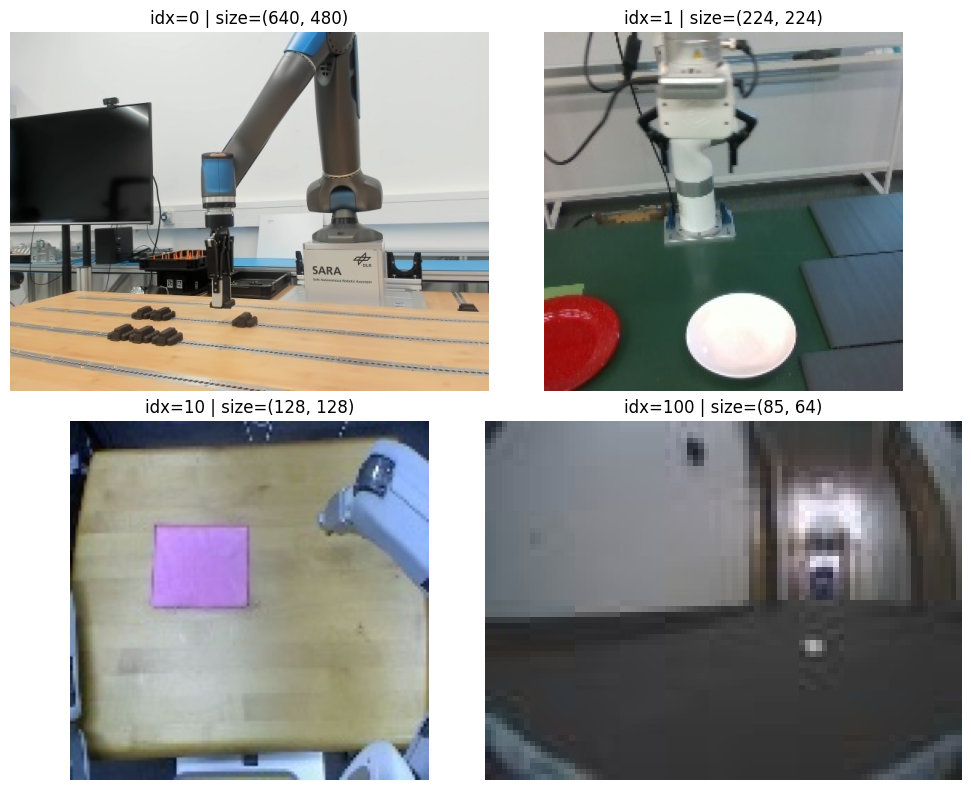

In [ ]:
from datasets import load_dataset
from google.colab import userdata
import matplotlib.pyplot as plt
import random

repo_id = "AIRLab-POLIMI/oxe-bt-dataset"  # your org repo
HF_TOKEN = userdata.get("HF_TOKEN2") or userdata.get("HF_TOKEN")

ds = load_dataset(repo_id, token=HF_TOKEN)     # DatasetDict
train = ds["train"]                            # select split

idxs = [0, 1, 10, 100]
# idxs = random.sample(range(len(train)), 4)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

for ax, idx in zip(axs, idxs):
    ex = train[idx]
    img = ex["image"]  # PIL image (decode=True)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"idx={idx} | size={img.size}")

    print(f"\n===== IDX {idx} =====")
    print("USER:\n", ex["user_text"][:500], "\n")
    print("ASSISTANT:\n", ex["assistant_text"][:500])

plt.tight_layout()
plt.show()
